<a href="https://colab.research.google.com/github/OmobaR/Football-Data-Predictions/blob/main/AlphaBetSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Loading and Preprocessing
In this section, we load the dataset, perform basic data cleaning, and engineer new features. We aim to predict match outcomes using machine learning models.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)



# Load the dataset (Assume the data is stored in CSV)
data = pd.read_csv('SpanishSegunda.csv')

# Convert date to proper datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# Extract useful columns for further preprocessing
columns = ['Date', 'Season', 'Home Team', 'Away Team', '1', 'X', '2', 'HG', 'AG', 'Result']
df = data[columns]

# Basic data checks
print(df.head())


        Date  Season Home Team  Away Team     1     X     2  HG  AG Result
0 2024-09-16    2024   Almeria  Castellon  2.12  3.41  3.23   2   5      A
1 2024-09-15    2024     Elche    Granada  2.26  3.22  3.14   2   2      D
2 2024-09-15    2024     Cadiz     Ferrol  1.65  3.69  5.18   0   0      D
3 2024-09-15    2024    Burgos   Zaragoza  2.37  3.09  3.05   1   0      H
4 2024-09-15    2024    Oviedo  Cartagena  1.70  3.44  5.20   1   0      H


### Feature Engineering
We will create new features based on previous match performance, including home and away wins, goals, and Elo ratings.


In [ ]:
import pandas as pd

# Assuming df is your DataFrame
n = 5  # Number of previous matches to consider

# Helper function to calculate win/loss from 'Result'
def calculate_wins_losses(row):
    if row['Result'] == 'H':  # Home win
        return 1, 0
    elif row['Result'] == 'A':  # Away win
        return 0, 1
    else:  # Draw
        return 0, 0

# Apply the function to calculate wins and losses for both home and away teams
df['home_win'], df['away_loss'] = zip(*df.apply(calculate_wins_losses, axis=1))
df['away_win'], df['home_loss'] = zip(*df.apply(lambda row: calculate_wins_losses({'Result': 'A' if row['Result'] == 'A' else 'H'}) if row['Result'] != 'D' else (0, 0), axis=1))

# Rolling window for calculating Home Team stats
df['HW'] = df.groupby('Home Team')['home_win'].rolling(n, min_periods=1).sum().reset_index(0, drop=True)  # Home Wins
df['HL'] = df.groupby('Home Team')['home_loss'].rolling(n, min_periods=1).sum().reset_index(0, drop=True)  # Home Losses
df['HGF'] = df.groupby('Home Team')['HG'].rolling(n, min_periods=1).sum().reset_index(0, drop=True)  # Home Goals For
df['HGA'] = df.groupby('Home Team')['AG'].rolling(n, min_periods=1).sum().reset_index(0, drop=True)  # Home Goals Against
df['HWGD'] = df['HGF'] - df['HGA']  # Home Win Goal Difference
df['HLGD'] = df['HGA'] - df['HGF']  # Home Loss Goal Difference

# Calculate percentages
df['HW%'] = df['HW'] / (df['HW'] + df['HL'])
df['HL%'] = df['HL'] / (df['HW'] + df['HL'])

# Rolling window for calculating Away Team stats
df['AW'] = df.groupby('Away Team')['away_win'].rolling(n, min_periods=1).sum().reset_index(0, drop=True)  # Away Wins
df['AL'] = df.groupby('Away Team')['away_loss'].rolling(n, min_periods=1).sum().reset_index(0, drop=True)  # Away Losses
df['AGF'] = df.groupby('Away Team')['AG'].rolling(n, min_periods=1).sum().reset_index(0, drop=True)  # Away Goals For
df['AGA'] = df.groupby('Away Team')['HG'].rolling(n, min_periods=1).sum().reset_index(0, drop=True)  # Away Goals Against
df['AWGD'] = df['AGF'] - df['AGA']  # Away Win Goal Difference
df['ALGD'] = df['AGA'] - df['AGF']  # Away Loss Goal Difference


# Calculate percentages
df['AW%'] = df['AW'] / (df['AW'] + df['AL'])
df['AL%'] = df['AL'] / (df['AW'] + df['AL'])

# ---- Additional Features for Full Objectives ----

# 1. Betting Odds (Implied Probabilities)
df['Implied_Home_Prob'] = 1 / df['1']
df['Implied_Draw_Prob'] = 1 / df['X']
df['Implied_Away_Prob'] = 1 / df['2']

# Normalize the implied probabilities so that they sum to 1
df['Implied_Home_Prob'] /= df[['Implied_Home_Prob', 'Implied_Draw_Prob', 'Implied_Away_Prob']].sum(axis=1)

# ---- Refined Elo Ratings (Offensive and Defensive Ratings) ----

def calculate_spi_ratings(df, k=20):
    teams = pd.concat([df['Home Team'], df['Away Team']]).unique()  # Get list of teams
    # Initialize offensive and defensive Elo ratings
    ratings = {
        team: {
            'offensive': 1500,  # Offensive rating
            'defensive': 1500   # Defensive rating
        } for team in teams
    }

    def update_ratings(home_off, home_def, away_off, away_def, home_goals, away_goals, k=20):
        # Calculate expected goals based on ratings
        expected_home_goals = (home_off / away_def) * 1.5  # Scaling factor can be tuned
        expected_away_goals = (away_off / home_def) * 1.5

        # Update offensive and defensive ratings based on actual vs. expected goals
        new_home_off = home_off + k * (home_goals - expected_home_goals)
        new_away_off = away_off + k * (away_goals - expected_away_goals)

        new_home_def = home_def + k * (expected_away_goals - away_goals)
        new_away_def = away_def + k * (expected_home_goals - home_goals)

        return new_home_off, new_home_def, new_away_off, new_away_def

    # Apply Elo ratings update after each match
    for index, row in df.iterrows():
        home_team = row['Home Team']
        away_team = row['Away Team']
        home_goals = row['HG']
        away_goals = row['AG']

        # Current offensive and defensive ratings for both teams
        home_off = ratings[home_team]['offensive']
        home_def = ratings[home_team]['defensive']
        away_off = ratings[away_team]['offensive']
        away_def = ratings[away_team]['defensive']

        # Update the ratings after the match based on goals scored and conceded
        new_home_off, new_home_def, new_away_off, new_away_def = update_ratings(
            home_off, home_def, away_off, away_def, home_goals, away_goals, k
        )

        # Save the updated ratings back into the dictionary
        ratings[home_team]['offensive'], ratings[home_team]['defensive'] = new_home_off, new_home_def
        ratings[away_team]['offensive'], ratings[away_team]['defensive'] = new_away_off, new_away_def

        # Store the ratings in the DataFrame
        df.loc[index, 'Home_Offensive_Elo'] = new_home_off
        df.loc[index, 'Home_Defensive_Elo'] = new_home_def
        df.loc[index, 'Away_Offensive_Elo'] = new_away_off
        df.loc[index, 'Away_Defensive_Elo'] = new_away_def

    return df

# Apply SPI-like rating calculation
df = calculate_spi_ratings(df)

# ---- Update Additional Features with Refined Elo Ratings ----

# 2. Opponent Strength Adjustments (based on refined offensive/defensive Elo Ratings)
df['Adj_Home_Form'] = df['HW%'] / df['Away_Defensive_Elo']
df['Adj_Away_Form'] = df['AW%'] / df['Home_Defensive_Elo']

# 3. Expected Goals (based on offensive and defensive Elo ratings)
df['Expected_Home_Goals'] = df['Home_Offensive_Elo'] / df['Away_Defensive_Elo']
df['Expected_Away_Goals'] = df['Away_Offensive_Elo'] / df['Home_Defensive_Elo']

# Fix NaN values in HW% and HL%
df['HW%'] = df['HW%'].fillna(0)  # Set NaN values to 0 where no games played
df['HL%'] = df['HL%'].fillna(0)

# Fix NaN values in AW% and AL%
df['AW%'] = df['AW%'].fillna(0)
df['AL%'] = df['AL%'].fillna(0)

# Fix NaN values in Adj_Home_Form and Adj_Away_Form (Opponent Strength Adjustments)
df['Adj_Home_Form'] = df['Adj_Home_Form'].fillna(0)  # Set NaN values to 0
df['Adj_Away_Form'] = df['Adj_Away_Form'].fillna(0)


# Check the engineered columns including refined Elo ratings
print(df[['Home Team', 'Away Team', 'Home_Offensive_Elo', 'Home_Defensive_Elo', 'Away_Offensive_Elo', 'Away_Defensive_Elo', 'Adj_Home_Form', 'Expected_Home_Goals']].head())


  Home Team  Away Team  Home_Offensive_Elo  Home_Defensive_Elo  Away_Offensive_Elo  Away_Defensive_Elo  Adj_Home_Form  Expected_Home_Goals
0   Almeria  Castellon              1510.0              1430.0              1570.0              1490.0       0.000000             1.013423
1     Elche    Granada              1510.0              1490.0              1510.0              1490.0       0.000000             1.013423
2     Cadiz     Ferrol              1470.0              1530.0              1470.0              1530.0       0.000000             0.960784
3    Burgos   Zaragoza              1490.0              1530.0              1470.0              1510.0       0.000662             0.986755
4    Oviedo  Cartagena              1490.0              1530.0              1470.0              1510.0       0.000662             0.986755


In [ ]:
df.head()

,Date,Season,Home Team,Away Team,1,X,2,HG,AG,Result,home_win,away_loss,away_win,home_loss,HW,HL,HGF,HGA,HWGD,HLGD,HW%,HL%,AW,AL,AGF,AGA,AWGD,ALGD,AW%,AL%,Implied_Home_Prob,Implied_Draw_Prob,Implied_Away_Prob,Home_Offensive_Elo,Home_Defensive_Elo,Away_Offensive_Elo,Away_Defensive_Elo,Adj_Home_Form,Adj_Away_Form,Expected_Home_Goals,Expected_Away_Goals
0,2024-09-16,2024,Almeria,Castellon,2.12,3.41,3.23,2,5,A,0,1,0,1,0.0,1.0,2.0,5.0,-3.0,3.0,0.0,1.0,0.0,1.0,5.0,2.0,3.0,-3.0,0.0,1.0,0.438972,0.293255,0.309598,1510.0,1430.0,1570.0,1490.0,0.000000,0.000000,1.013423,1.097902
1,2024-09-15,2024,Elche,Granada,2.26,3.22,3.14,2,2,D,0,0,0,0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.412949,0.310559,0.318471,1510.0,1490.0,1510.0,1490.0,0.000000,0.000000,1.013423,1.013423
2,2024-09-15,2024,Cadiz,Ferrol,1.65,3.69,5.18,0,0,D,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.566352,0.271003,0.193050,1470.0,1530.0,1470.0,1530.0,0.000000,0.000000,0.960784,0.960784
3,2024-09-15,2024,Burgos,Zaragoza,2.37,3.09,3.05,1,0,H,1,0,1,0,1.0,0.0,1.0,0.0,1.0,-1.0,1.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0,0.393076,0.323625,0.327869,1490.0,1530.0,1470.0,1510.0,0.000662,0.000654,0.986755,0.960784
4,2024-09-15,2024,Oviedo,Cartagena,1.70,3.44,5.20,1,0,H,1,0,1,0,1.0,0.0,1.0,0.0,1.0,-1.0,1.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0,0.549116,0.290698,0.192308,1490.0,1530.0,1470.0,1510.0,0.000662,0.000654,0.986755,0.960784


In [ ]:
# Encode target 'Result' (H=1, D=0, A=-1)
df['Result_Numeric'] = df['Result'].map({'H': 0, 'D': 1, 'A': 2})

# Check the encoding
print(df[['Result', 'Result_Numeric']].head())


  Result  Result_Numeric
0      A               2
1      D               1
2      D               1
3      H               0
4      H               0


In [ ]:
# Transform Team names via label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Home Team'] = label_encoder.fit_transform(df['Home Team'])
df['Away Team'] = label_encoder.transform(df['Away Team'])


In [ ]:
# Assuming 'Date' is the column with datetime data, convert it to days since a reference date
df['Date'] = pd.to_datetime(df['Date'])
df['days_since_reference'] = (df['Date'] - pd.Timestamp('1970-01-01')).dt.days

# Drop the original 'Date' column
df = df.drop(columns=['Date'])


In [ ]:
# Drop columns directly related to the result of the current match
drop_columns = ['HG', 'AG', 'home_win', 'away_loss', 'away_win', 'home_loss', 'Result', 'Result_Numeric']

# Keep the cumulative features, betting odds, and Elo-based features
df_clean = df.drop(columns=drop_columns)

# Now, we encode the 'Result' column (your target variable) separately, assuming it was encoded before
# Assuming 'Result_Encoded' is a pre-encoded version of 'Result' where H = 1, D = 0, A = -1 (or any other encoding)

X = df_clean  # Features after dropping the columns
y = df['Result_Numeric']  # Assuming you already encoded the target


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')  # Use class_weight to handle imbalance
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.64      0.67       373
           1       0.51      0.41      0.45       274
           2       0.49      0.72      0.59       196

    accuracy                           0.58       843
   macro avg       0.57      0.59      0.57       843
weighted avg       0.59      0.58      0.58       843

Confusion Matrix:
 [[238  79  56]
 [ 72 111  91]
 [ 25  29 142]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Drop columns directly related to the result of the current match
drop_columns = ['HG', 'AG', 'home_win', 'away_loss', 'away_win', 'home_loss', 'Result', 'Result_Numeric']

# Keep cumulative features, betting odds, and Elo-based features
df_clean = df.drop(columns=drop_columns)

# Now, we encode the 'Result' column (your target variable) separately
# Assuming 'Result_Encoded' is a pre-encoded version of 'Result' where H = 1, D = 0, A = -1 (or any other encoding)

X = df_clean  # Features after dropping the columns
y = df['Result_Numeric']  # Assuming you already encoded the target

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))



Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       377
           1       0.67      0.48      0.56       261
           2       0.59      0.68      0.63       205

    accuracy                           0.67       843
   macro avg       0.66      0.65      0.65       843
weighted avg       0.67      0.67      0.66       843

Confusion Matrix:
 [[299  34  44]
 [ 82 125  54]
 [ 38  27 140]]


In [ ]:
# Drop columns directly related to the result of the current match
drop_columns = ['HG', 'AG', 'home_win', 'away_loss', 'away_win', 'home_loss', 'Result', 'Result_Numeric']

# Keep the cumulative features, betting odds, and Elo-based features
df_clean = df.drop(columns=drop_columns)

# Now, we encode the 'Result' column (your target variable) separately, assuming it was encoded before
# Assuming 'Result_Encoded' is a pre-encoded version of 'Result' where H = 1, D = 0, A = -1 (or any other encoding)

X = df_clean  # Features after dropping the columns
y = df['Result_Numeric']  # Assuming you already encoded the target

# Split the data into training and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost model
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

xgb_model = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=1)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:25:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       377
           1       0.61      0.56      0.58       261
           2       0.61      0.63      0.62       205

    accuracy                           0.66       843
   macro avg       0.65      0.64      0.64       843
weighted avg       0.66      0.66      0.66       843

Confusion Matrix:
 [[281  59  37]
 [ 69 146  46]
 [ 42  34 129]]


#Handling Class Imbalance
We’ve already applied class balancing through class_weight='balanced' in both the Logistic Regression and Random Forest models, and scale_pos_weight in XGBoost. If you'd like to use oversampling, you can use the SMOTE technique:

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE for oversampling
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Train Random Forest with SMOTE-applied data
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_rf_smote = rf_model_smote.predict(X_test)

# Evaluate the model
print("Random Forest with SMOTE Classification Report:\n")
print(classification_report(y_test, y_pred_rf_smote))


Random Forest with SMOTE Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       377
           1       0.65      0.51      0.57       261
           2       0.58      0.73      0.65       205

    accuracy                           0.67       843
   macro avg       0.66      0.66      0.65       843
weighted avg       0.67      0.67      0.67       843



# Feature Importance (Random Forest & XGBoost)
To understand which features are most important, let’s extract and visualize feature importance from both Random Forest and XGBoost models.

Random Forest Feature Importance:

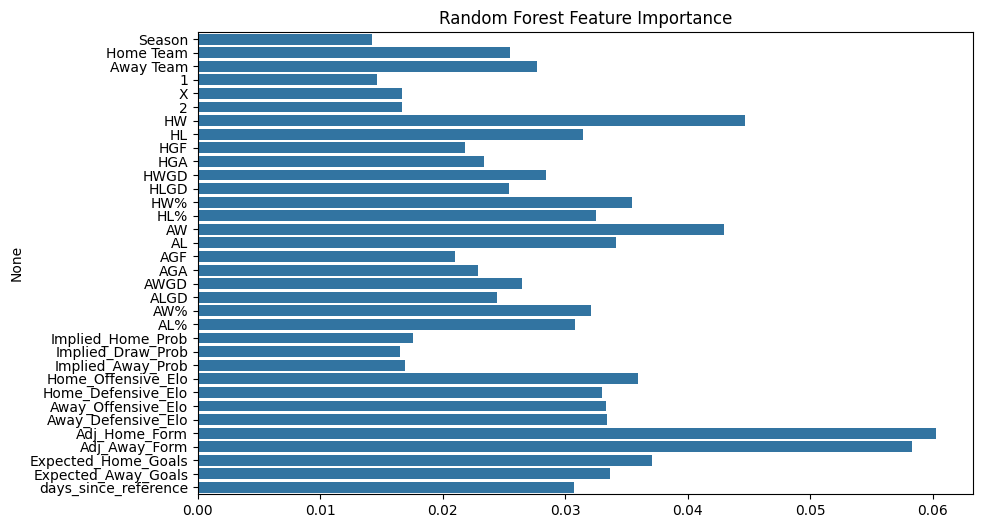

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance for Random Forest
importance_rf = rf_model.feature_importances_
features_list = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_rf, y=features_list)
plt.title("Random Forest Feature Importance")
plt.show()


#XGBoost Feature Importance:

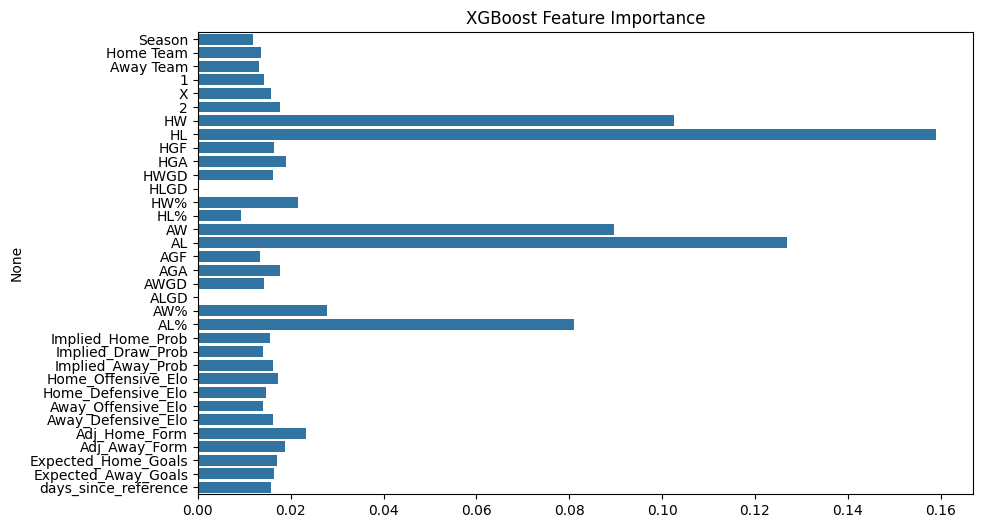

In [ ]:
# Feature importance for XGBoost
importance_xgb = xgb_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_xgb, y=features_list)
plt.title("XGBoost Feature Importance")
plt.show()

# Cross-Validation
Let’s implement Stratified K-Fold Cross-Validation to ensure balanced splits in each fold, which is crucial when dealing with class imbalance.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5)

# Perform cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring='f1_macro')  # Use F1-macro for class imbalance
print("Random Forest Cross-Validation Scores: ", cv_scores_rf)
print("Random Forest Average CV Score: ", cv_scores_rf.mean())

# Perform cross-validation for XGBoost
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=skf, scoring='f1_macro')
print("XGBoost Cross-Validation Scores: ", cv_scores_xgb)
print("XGBoost Average CV Score: ", cv_scores_xgb.mean())


Random Forest Cross-Validation Scores:  [0.63271237 0.67750737 0.62758552 0.66573039 0.64381815]
Random Forest Average CV Score:  0.6494707602242104


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:33:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:33:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:33:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:33:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weigh

XGBoost Cross-Validation Scores:  [0.62954437 0.63405125 0.63464185 0.66072331 0.64082489]
XGBoost Average CV Score:  0.6399571325812379


# Model Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV for hyperparameter tuning.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=skf, scoring='f1_macro', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for Random Forest: ", grid_search_rf.best_params_)
print("Best score for Random Forest: ", grid_search_rf.best_score_)


Best parameters for Random Forest:  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best score for Random Forest:  0.657203043312008
